# Privacy Preserving Machine Learning

Practical Session taken from the Course of Aurélien Bellet

Course page: http://researchers.lille.inria.fr/abellet/teaching/private_machine_learning_course.html


# Part 1: Differential privacy for numeric queries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml # need sklearn >= 0.22
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC

Below we provide a helper function to draw bar plots from pandas Series.

In [2]:
def bar_plot_pandas(series1, series2=None, label1="Series 1", label2="Series 2", title=""):
    '''
    Draws a bar plot of one Pandas Series, or two pandas Series with the same index
    
    Parameters
    ----------
    series1 : Series of float
        First input
    series2 : Series of float, optional
        Second input (with same index)
    label1 : string, optional
        Label for the first series
    label2 : string, optional
        Label for the second series
    title : string, optional
        Plot title
    '''
    if series2 is None:
        series1.plot.bar()
        plt.legend([label1])
    else:
        concat_series = pd.DataFrame({label1: series1, label2: series2}).reset_index()
        concat_series.plot.bar(x="index", y=[label1, label2], xlabel="", title=title)

## Dataset

We will be working with a dataset from the US Census (also known as the Adult dataset). You can read about the dataset [here](https://archive.ics.uci.edu/ml/datasets/census+income).

The following line loads the dataset from [OpenML](https://www.openml.org/) with the `fetch_openml` method of `sklearn`. The option `as_frame=True` (**requires sklearn version >= 0.22**) loads the dataset in `pandas DataFrame` format: this keeps the attributes in their original form and will be more convenient to work with. If you prefer working with a numpy array (not recommended), set `as_frame=False`.

In [3]:
dataset_handle = fetch_openml(name='adult', version=2, as_frame=True)
dataset = dataset_handle.frame

c:\Users\eline\venv\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Take a look at the dataset, in particular the number of rows (individuals), the number of columns (attributes) and what they represent.

In [4]:
n, d = dataset.shape
print(n, d)
dataset.head(10)

48842 15


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
5,34.0,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
6,29.0,NaN,227026.0,HS-grad,9.0,Never-married,NaN,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K
7,63.0,Self-emp-not-inc,104626.0,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103.0,0.0,32.0,United-States,>50K
8,24.0,Private,369667.0,Some-college,10.0,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
9,55.0,Private,104996.0,7th-8th,4.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,10.0,United-States,<=50K


In [5]:
dataset['marital-status'].value_counts()

marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64

## Question 1 (non-private queries)

Implement a function for each of these types of queries (without privacy) and test them on the dataset:
- **Simple count queries**: it takes as input a dataset (`DataFrame`), a categorical attribute (e.g., `"sex"`) and a value (e.g., `"Male"`), and returns how many rows in the dataset have the prescribed attribute value.
- **Averaging queries**: it takes as input a dataset and a numeric attribute (e.g., `"age"`), and returns the average value of this attribute in the dataset.
- **Histogram queries**: it takes as input a dataset and a categorical attribute (e.g., `"sex"`), and returns the histogram of counts for this attribute in the dataset (i.e., for each possible value of the attribute, how many rows have this value).

Reminder: for a DataFrame `df`, we can access the column corresponding to an attribute `attr` by `df[attr]`. The method `value_counts()` allows to build a histogram of a column. To plot a pandas Series `s` as a histogram, you can use `s.plot.bar()`.

Note: You can use the function `bar_plot_pandas` provided in the preamble to draw a bar plot of a pandas Series, which is useful to show histograms.

In [6]:
def count_query(df, attribute, value):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
    value : string or int
        Value of attribute to count
        
    Returns
    -------
    count : int
        The number of records with `attribute=value` in dataset `df`
    '''
    
    # TO COMPLETE
    return df[attribute].value_counts()[value]

In [7]:
def average_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with numeric values
        
    Returns
    -------
    average : float
        The average value of `attribute` in dataset `df`
    '''
        
    # TO COMPLETE
    return df[attribute].mean()

In [8]:
def histogram_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
        
    Returns
    -------
    histogram : array or Series of int
        The histogram of `attribute`, i.e., the number of times each value of `attribute` appears in `df`
    '''
    # TO COMPLETE
    return df[attribute].value_counts()

## Question 2 (Laplace mechanism)

Implement the Laplace mechanism, i.e., a function which takes as input a (non-private) query output, the query's $\ell_1$ sensitivity, the desired value of $\epsilon$ and a random seed (for reproducibility), and returns a $\epsilon$-differentially private estimate of the query. To draw Laplace noise, check `np.random.laplace`. The function should work with queries that output a scalar (like simple count and averaging queries), as well as those that output a vector (like histogram queries).

In [9]:
def laplace_mechanism(q, s1, eps, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s1 : float
        The L1 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    random_state : int, optional (default=None)
        Random seed
        
    Returns
    -------
    private_q : float or array/Series of float
        An eps-DP evaluation of the query
    '''

    rng = np.random.RandomState(random_state)
    
    # TO COMPLETE
    if hasattr(q, 'shape'): # query output is multi-dimensional
        shape = q.shape
        names = q.index
        v = q.values.flatten()
        z = np.random.laplace(loc = 0, scale = s1/eps, size = len(v)).reshape(shape) 
        return pd.Series(v + z, index = names)
    else: # query output is a scalar
        v = q
        z = np.random.laplace(loc = 0, scale = s1/eps, size = len(v))
        return v + z
    

In [10]:
histogram_query(dataset, 'education')

education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

In [11]:
laplace_mechanism(histogram_query(dataset, 'education'), 1, 1, 0)

education
HS-grad         15783.016978
Some-college    10877.881383
Bachelors        8025.154170
Masters          2658.287703
Assoc-voc        2061.266354
11th             1810.883336
Assoc-acdm       1601.160774
10th             1388.756944
7th-8th           954.772695
Prof-school       834.096213
9th               757.258822
12th              658.051825
Doctorate         594.146461
5th-6th           506.941531
1st-4th           244.808244
Preschool          82.265551
dtype: float64

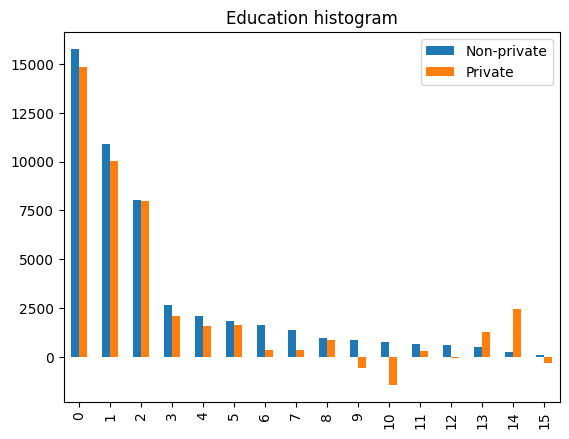

In [12]:
s1 = 1
eps = 0.001
non_private = histogram_query(dataset, 'education')
private = laplace_mechanism(non_private, s1, eps, 0)
bar_plot_pandas(non_private.values, private.values, "Non-private", "Private", "Education histogram")

## Question 3 (Laplace mechanism on count queries)

We would like to use the Laplace mechanism to:
- privately count the number of males in the dataset
- generate a private histogram of the `"workclass"` attribute

What is the sensitivity of the query in each case?

Run the Laplace mechanism with different values of $\epsilon$ and compute the $\ell_1$-error with respect to the true (non-private) output to see the effect on the utility and compare with the formal error bound seen in the lecture. Recall that the mechanism is random, so unless you fix the seed you will get a different result at each execution. Visually compare the private and non-private histograms using the function `bar_plot_pandas` provided at the beginning of the notebook.

Note: you may round the outputs of the private mechanism to make them integers if you like. This can be considered as post-processing and thus preserves DP (see Bonus Question 5 to go further on this aspect).

*Answer :* The sensitivity of the first query is 1. For the second, it is 2.

In [13]:
def l1_error(a, b):
    '''
    Parameters
    ----------
    a : float or array/Series of float
        First input
    b : float or array/Series of float
        Second input
        
    Returns
    -------
    l1_error : float
        The L1 distance between `a` and `b`: ||a-b||_1
    '''

    # TO COMPLETE
    return np.linalg.norm(a-b, ord =1)

## Question 4 (Laplace mechanism on average queries)

We would like to use the Laplace mechanism to privately estimate the average age of people in the dataset. We assume that the number of people in the dataset is public.

1. Propose and implement simple practical strategies to compute or estimate the sensitivity of this query in the following two scenarios, and discuss the merits and/or drawbacks of your proposals:
  - You are the trusted curator: you have access to the raw dataset and would like to release an estimate of the average age of people in the dataset with differential privacy guarantees.
  - You are an external data analyst: you do not have access to the raw dataset but only to an API to send queries. You have to convince the trusted curator that the proposed sensitivity is safe.
2. Suggest some ideas regarding how we could change a bit the query to get a simple and safe bound on sensitivity, at the expense of possibly introducing some bias in the output. Implement the proposed solution. Hint: the method `clip` from pandas might be useful here.

*Answer :* 

**1.**  First scenario : We can decide to remove from our dataset everyone older then 100 y.o. Thus, we can use $100/n$

Second scenario : Same, but we cannot take anyone from the dataset, so we assume that no one is older than 100 y.o. For instance, we can take 99% of the public data on age related death, and divide it by the number of people in the dataset. 
Instead of assuming, we can use the query to get the maximum age.

**2.**  We can clip from 0 to 100 years old.

## Question 5 (average over a subset)

We would now like to compute the average age of divorced people. How can we use the Laplace mechanism to privately answer this query? Implement your solution.

In [14]:
# Laplacien on the age & Bernoulli mechanism on the marital status (non-divorced / divorced)
from copy import deepcopy

def bernoulli_replacement(dataset, p,q):
    for i in range(len(dataset)):
        if np.random.uniform() < p:
            dataset[i] = dataset[i]
        else:
            dataset[i] = ('Divorced' if np.random.uniform() < q else "Widowed")

series_marital = deepcopy(dataset['marital-status'])
bernoulli_replacement(series_marital, 0.8, 0.3)

series_age = deepcopy(dataset['age'])
series_age = laplace_mechanism(series_age, 1, 1, 0)

output = np.mean(series_age[series_marital == 'Divorced'])
print(output)


41.57282305209905


In [15]:
dataset[dataset['marital-status'] == 'Divorced']['age'].mean()

43.159203980099505

## Question 6 (Gaussian mechanism and comparison with Laplace)

Implement the Gaussian mechanism (to draw Gaussian noise, check `np.random.normal`). Make an experimental comparison with the Laplace mechanism by plotting the privacy-utility trade-off for a 1D query of your choice. For the Gaussian mechanism, study the influence of $\delta$.

In [16]:
def gaussian_mechanism(q, s2, eps, delta, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s2 : float
        The L2 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    delta : float
        Parameter delta of differential privacy
    random_state : int, optional (default=None)
        Random seed
        
    Returns
    -------
    private_q : float or array/Series of float
        An (eps,delta)-DP evaluation of the query
    '''
    
    rng = np.random.RandomState(random_state)
    
    # TO COMPLETE
    if hasattr(q, 'shape'): # query output is multi-dimensional
        pass
    else: # query output is a scalar
        pass

C:\Users\eline\AppData\Local\Temp\ipykernel_26112\1911973316.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


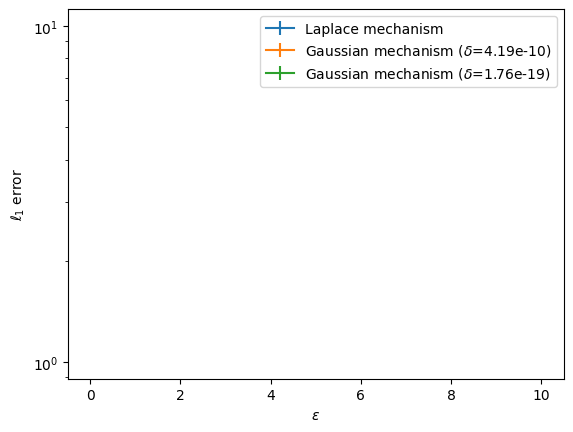

In [17]:
# q = 
# s = 
eps_list = np.linspace(0.01, 10.0, num=20)
delta1 = 1. / n**2
delta2 = 1. / n**4
n_runs = 50

error = np.zeros((len(eps_list), 3, n_runs))

for i, eps in enumerate(eps_list):
    for r in range(n_runs):
        # error[i, 0, r] = 
        # error[i, 1, r] = 
        # error[i, 2, r] = 
        pass
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(eps_list, error[:, 0, :].mean(axis=1), error[:, 0, :].std(axis=1), label='Laplace mechanism')
ax.errorbar(eps_list, error[:, 1, :].mean(axis=1), error[:, 1, :].std(axis=1),
            label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta1) + ')')
ax.errorbar(eps_list, error[:, 2, :].mean(axis=1), error[:, 2, :].std(axis=1),
            label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta2) + ')')
plt.xlabel("$\epsilon$")
plt.ylabel("$\ell_1$ error")
ax.set_yscale('log')
ax.legend()

# Part 2: Differential privacy for non-numeric queries 

## Question 1 ("most common" query)

Implement a function for "most common" queries: it takes as input a dataset (`DataFrame`), an attribute (e.g., `"education"`), and returns the most common value of this attribute in the dataset (ties can be broken arbitrarily). Note that in general, the output of such queries is non-numeric. The pandas methods `value_counts`, `idxmax()` or `mode` can be useful here.

Test your function on the dataset.

In [26]:
def most_common_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute (with categorical values)
        
    Returns
    -------
    value : float or string
        The most common value of `attribute` in dataset `df`
    '''
    
    # TO COMPLETE
    return df[attribute].value_counts().idxmax()

In [27]:
most_common_query(dataset, 'education')

'HS-grad'

## Question 2 (Exponential mechanism)

Implement the exponential mechanism, i.e., a function which takes as input the list of possible outputs, the corresponding scores (assuming a numpy array format will be most convenient), the sensitivity of the score function, the desired value of $\epsilon$ and a random seed (for reproducibility), and returns an output selected in an $\epsilon$-differentially private way. To sample an ouput, use `numpy.random.choice`.

**Careful**: if you implement the exponential mechanism naively you will get numerical errors because un-normalized probabilities will quickly become very large. You should compute everything in log domain and only take the exponential at the end. To compute the normalization term in log domain, you can use `scipy.special.logsumexp`.

In [49]:
import scipy

def exponential_mechanism(outputs, scores, sensitivity, eps, random_state=None):
    '''
    Parameters
    ----------
    outputs : list
        Possible outputs for the query
    scores : array of float 
        Scores associated to each output
    sensitivity : float
        The sensitivity of the score
    eps : float
        Parameter epsilon of differential privacy
    random_state : int, optional (default=None)
        Random seed
        
    Returns
    -------
    private_q : float or string (sans as outputs)
        An eps-DP evaluation of the query
    '''
    
    rng = np.random.RandomState(random_state)
    # TO COMPLETE
    log_probabilities = (eps * scores / (2 * sensitivity))
    log_probabilities -= scipy.special.logsumexp(log_probabilities) # normalize
    probabilities = np.exp(log_probabilities) # on repasse à l'exp
    # print(probabilities)
    return np.random.choice(outputs, p=probabilities)


In [50]:
#test
outputs = [0, 1, 2, 3]
scores = np.array([0, 1, 2, 3])
sensitivity = 1
eps = 1
exponential_mechanism(outputs, scores, sensitivity, eps, 0)

3

## Question 3 (Exponential mechanism on "most common" queries)

We would like to use the exponential mechanism to privately answer the following queries:
- What is the most common level of education of people in the dataset?
- What is the most common occupation of people in the dataset?
- What is the most common age of people in the dataset?

Define an appropriate score function for these queries. What is the sensitivity of your score function?

Use the exponential mechanism to privately answer these queries for $\epsilon=0.1$ and several random executions. Compare the output to the non-private result, and explain why for some queries the true (non-private) output is returned more often.

In [51]:
dataset.value_counts('education')

education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

In [52]:
def private_most_common_query(df, attribute, eps, random_state=None):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute (with categorical values)
    eps : float
        Parameter epsilon of differential privacy
    random_state : int, optional (default=None)
        Random seed
        
    Returns
    -------
    private_q : float or string
        An eps-DP evaluation of the "most common" query on `attribute`
    '''
    
    d = dict(df[attribute].value_counts())
    outputs = list(d.keys())
    # TO COMPLETE
    scores = np.array(list(d.values()))
    outputs = np.array(list(d.keys()))
    sensitivity = 1
    return exponential_mechanism(outputs, scores, sensitivity, eps, None)

    

In [53]:
query_attribute = ['education', 'occupation', 'age']

for attr in query_attribute:
    print("\nAttribute queries:", attr)
    for r in range(20):
        print(private_most_common_query(dataset, attr, 0.1, None))


Attribute queries: education
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad
HS-grad

Attribute queries: occupation
Prof-specialty
Craft-repair
Prof-specialty
Prof-specialty
Exec-managerial
Prof-specialty
Prof-specialty
Prof-specialty
Prof-specialty
Prof-specialty
Prof-specialty
Prof-specialty
Prof-specialty
Prof-specialty
Prof-specialty
Prof-specialty
Craft-repair
Prof-specialty
Prof-specialty
Prof-specialty

Attribute queries: age
31.0
33.0
31.0
35.0
36.0
23.0
36.0
36.0
36.0
34.0
33.0
33.0
23.0
35.0
23.0
36.0
36.0
34.0
28.0
35.0


## Question 4 (Exponential mechanism for model selection)

Suppose that you would like to build a model to predict the income of an individual based on its personal features (for instance, to study which features are predictive of income). You have access to a small *public* dataset of 50 people in the same format as the US Census dataset we have been working with so far, and you would like to train a classifier to predict whether an individual makes more than 50$/year from its personal features. However, there are hyper-parameters to tune and you know the dataset is too small to reliably estimate the generalization performance of each model to select the best.

There exists a larger dataset held by the US Census on which you could perform model selection, but this dataset is *private*. Therefore you would like to privately perform model selection on this dataset, i.e., among the set of models you trained on the small public dataset, you would like to select the one which performs best on the private dataset in an $\epsilon$-DP fashion.

To simulate this scenario, we use the same dataset as before. For convenience, we load it in numpy format where all categorical features have been coded as numerical variables, and remove the features that have missing values. We then split the full dataset into a small dataset with 50 people (the *public* dataset) and a larger dataset of 48K+ people (the *private* dataset).

In [73]:
X, y = fetch_openml(name='adult', version=2, return_X_y=True, as_frame=False)
features_complete = (np.isnan(X).sum(axis=0)) == 0 # features without missing values
X = X[:, features_complete]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_public, X_private, y_public, y_private = train_test_split(X, y, train_size=50, random_state=42)
print(X_public.shape, y_public.shape, X_private.shape, y_private.shape)

c:\Users\eline\venv\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(50, 11) (50,) (48792, 11) (48792,)


1. What is the output space of the query?
2. How to define the score function in this case? What is its sensitivity?
3. Implement a function for private model selection with the exponential mechanism: it takes as input the public and the private datasets, a scikit-learn model (e.g., `LogisticRegression()`), a `ParameterGrid` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html)) giving the possible hyper-parameters and values, the desired value of $\epsilon$ and a random seed (for reproducibility), and returns a set of hyper-parameters selected in an $\epsilon$-DP way.
4. Run this to tune the value of the parameter `C` of `LogisticRegression()`. You may also try other cases, e.g., tuning the choice of kernel, parameter `C` and parameter `gamma` of the RBF kernel in a SVM model.

**Answers:**

**1)** The query is "What model should I consider", so the output is the model. And the output space is the set of considered models.

**2)** It is the accuracy of the models on the private set.

**3)** 

In [70]:
def private_model_selection(X_public, y_public, X_private, y_private, model, grid, eps, random_state=None):
    '''
    Parameters
    ----------
    X_public : array of shape (n1, d)
        Public dataset
    y_public : array of shape (n1,)
        Public labels
    X_private : array of shape (n2, d)
        Private dataset
    y_private : array of shape (n2,)
        Private labels
    model : BaseEstimator
        An instance of a scikit-learn model
    grid : ParameterGrid
        A grid describing the set of hyperparameters to tune and their possible values
    eps : float
        Parameter epsilon of differential privacy
    random_state : int, optional (default=None)
        Random seed
        
    Returns
    -------
    private_best_params : dict
        An eps-DP evaluation of best hyperparameter search
    '''

    n_private = X_private.shape[0]
    accuracies = np.zeros(len(grid))
    for i, param in enumerate(grid):
        model.set_params(**param)
        # TO COMPLETE
        model.fit(X_public, y_public)
        accuracies[i] = model.score(X_private, y_private)
    print('accuracies : ', accuracies)
    return exponential_mechanism(grid, accuracies, 1/n_private, eps, random_state)
    

In [72]:
params = {'C':np.geomspace(1e-3, 1e3, num=100)}
grid = ParameterGrid(params)
model = LogisticRegression(solver='liblinear')
# TO COMPLETE
private_model_selection(X_public, y_public, X_private, y_private, model, grid, 10000, None)

accuracies :  [0.79580669 0.79656501 0.79752828 0.79849156 0.8000082  0.80074602
 0.80203722 0.8042507  0.80662814 0.80820626 0.80982538 0.81091162
 0.81224381 0.81333005 0.81585096 0.81790048 0.81890474 0.82003197
 0.82083128 0.82128218 0.82156911 0.82195852 0.82191753 0.82093376
 0.82048287 0.81970405 0.81900721 0.81884325 0.81710116 0.81529759
 0.81367847 0.81232579 0.81136252 0.81050172 0.80953845 0.80912855
 0.80867765 0.80820626 0.80830874 0.80822676 0.80834973 0.80871864
 0.80843171 0.80869815 0.80898508 0.80955894 0.80951795 0.80970241
 0.80978439 0.81035826 0.81097311 0.81158797 0.81169044 0.81177242
 0.81203886 0.8126947  0.81287916 0.8131456  0.81359649 0.81371946
 0.81359649 0.8131251  0.81287916 0.8131251  0.81257173 0.81189539
 0.81117806 0.81025578 0.80968192 0.80857518 0.80777586 0.8076324
 0.80683309 0.80572635 0.80537793 0.80480407 0.80433268 0.80377931
 0.80291851 0.80216019 0.80129939 0.80047959 0.80004919 0.79972127
 0.79951631 0.7991474  0.79863502 0.79810215 0.79

{'C': 0.01873817422860384}

In [66]:
params = [{'kernel':['rbf'], 'gamma':np.geomspace(1e-4, 1e4, num=20), 'C': np.geomspace(1e-3, 1e3, num=10)},
              {'kernel':['linear'], 'C':np.geomspace(1e-3, 1e3, num=10)}]
grid = ParameterGrid(params)
model = SVC()
# TO COMPLETE
private_model_selection(X_public, y_public, X_private, y_private, model, grid, 0.1, None)

{'C': 10.0, 'gamma': 0.012742749857031334, 'kernel': 'rbf'}